In [5]:
import librosa
import numpy as np
import pyroomacoustics as pra
import soundfile as sf
from IPython.display import Audio, display


In [6]:

# Load the first audio file
y1, sr1 = librosa.load('files/man.mp3', sr=44100)

# Load the second audio file
y2, sr2 = librosa.load('files/monkey.mp3', sr=44100)

# Make sure both audio files have the same sample rate
if sr1 != sr2:
    raise ValueError("Sample rates must be the same")

# Trim or pad audio signals to the same length
min_len = min(len(y1), len(y2))
y1 = y1[:min_len]
y2 = y2[:min_len]

display(Audio(y1, rate=sr1))
display(Audio(y2, rate=sr1))


In [7]:

# Create an anechoic room
room_dim = np.r_[100., 100.]
aroom = pra.ShoeBox(
    room_dim,
    absorption=0.9,
    fs=sr1,
    max_order=0,
)

# Add sources to the room
aroom.add_source([2.5, 3.], signal=y1)
aroom.add_source([7.5, 7.5], signal=y2)

# Add a microphone array to the room
mic_locs = np.c_[
    [5., 5.],  # mic 1
    [5., 10.],  # mic 2
]
aroom.add_microphone_array(pra.MicrophoneArray(mic_locs, aroom.fs))

# Mix the sources and record the signals at the microphones
aroom.simulate()


mixed_sig = aroom.mic_array.signals.T
display(Audio(mixed_sig[:, 0], rate=sr1))
display(Audio(mixed_sig[:, 1], rate=sr1))


In [14]:
import numpy as np

def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

def whiten(X):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM


def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime 
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update counter
                i += 1

            W[c, :] = w.T
    return W


In [15]:
X = mixed_sig.T
X_centered, meanX = center(X)

# Whiten mixed signals
X_whitened, whitening_matrix = whiten(X_centered)

# Apply FastICA
W = fastIca(X_whitened,  alpha=1)

#Un-mix signals using 
unMixed = X_whitened.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

In [16]:
display(Audio(unMixed[:, 0], rate=sr1))
display(Audio(unMixed[:, 1], rate=sr1))

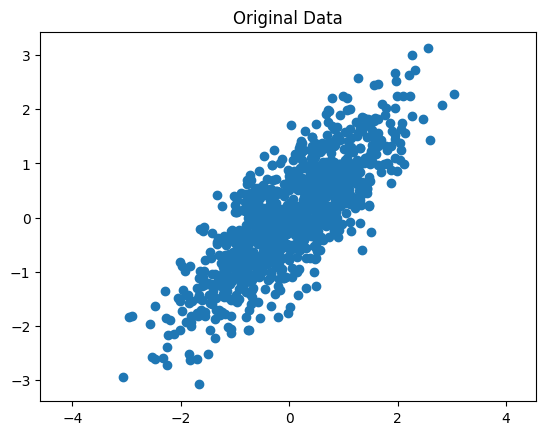

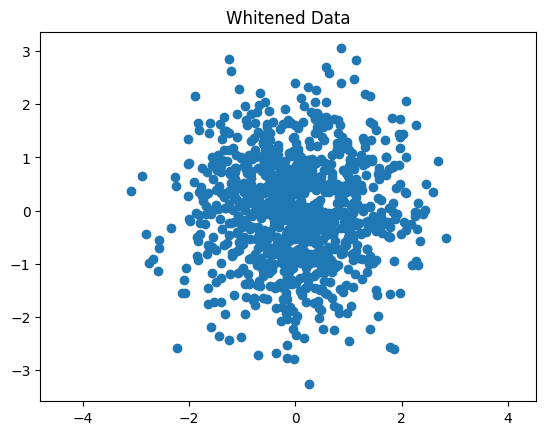

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
N = 1000  # Number of samples
M = 2  # Number of features
X = np.random.multivariate_normal([0, 0], [[1, 0.8], [0.8, 1]], N).T

# Plot original data
plt.figure()
plt.scatter(X[0], X[1])
plt.title('Original Data')
plt.axis('equal')

# Perform whitening
mean_X = np.mean(X, axis=1, keepdims=True)
X_centered = X - mean_X
cov_X = np.cov(X_centered)
eigvals, eigvecs = np.linalg.eigh(cov_X)
whitening_matrix = np.dot(np.diag(1.0 / np.sqrt(eigvals)), eigvecs.T)
X_whitened = np.dot(whitening_matrix, X_centered)

# Plot whitened data
plt.figure()
plt.scatter(X_whitened[0], X_whitened[1])
plt.title('Whitened Data')
plt.axis('equal')

plt.show()
